Exploring a dataset with information about patients. 
Consider next 8 features to predict the mortality rate:
1. Age
2. ОССН KiLLip
3. HBR (b)
4. Systolic AP(b)
5. Creatine in blood
6. EF Percentage
7. White blood cells count
8. Glucose

# 1. Import required libraries and load the dataset

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display

In [2]:
# Load dataset
raw_data = pd.read_excel('./import/DataSet_V47.xlsx')

columns_in_data = ['Age', 
           'ОССН KiLLip', 
           'ЧСС (b)', 
           'Систолическое АД(b)', 
           'Креатинин', 
           'EF%',
           'Лейкоциты(b)',
           'Глюкоза(a)',
           'начало операции',
           'Дата операции в БД',
           'дата выписки',
           'дата смерти',
           'Исход заболевания']

data=raw_data.loc[(raw_data['STEMI']== 'Да')  & 
                   (raw_data['Наличие в БД']== 'Да')  & 
                  (raw_data['Наличие в файле']== 'Да') &
                   (raw_data['ЧКВ']== 'Да'),
                   columns_in_data]

columns_to_check = ['Age',
                   'ЧСС (b)', 
                   'Систолическое АД(b)', 
                   'Креатинин',
                   'EF%', 
                   'Лейкоциты(b)',  
                   'Глюкоза(a)']

data_no_nan = data.dropna(subset=columns_to_check)

data_no_nan_copy = data_no_nan.copy()
for col_name in ['Дата операции в БД', 'дата выписки', 'дата смерти']:
    new_col_name = f"{col_name}_parsed"
    data_no_nan_copy[new_col_name] = pd.to_datetime(data_no_nan_copy[col_name], errors='coerce')

query_expression = "(not `дата смерти`.isnull() and `Исход заболевания` != 'умер')"

# Applying De Morgan's laws to the query
query_expression_2 = "(`дата смерти`.isnull() or `Исход заболевания` == 'умер')"

# Drop rows that satisfy the query expression
clean_data = data_no_nan_copy.query(query_expression_2)

mask = (
    (clean_data['дата смерти_parsed'].notna()) & 
                (clean_data['дата смерти_parsed'] - clean_data['Дата операции в БД_parsed'] > pd.Timedelta('55 days'))
    | ((clean_data['дата смерти_parsed'].isna()) & 
                (clean_data['Исход заболевания'] == 'умер') & 
                (clean_data['дата выписки_parsed'].notna()) & 
                (clean_data['дата выписки_parsed'] - clean_data['Дата операции в БД_parsed'] > pd.Timedelta('55 days'))
        )
)

rows_to_keep = ~mask
ready_data = clean_data[rows_to_keep]
ready_data.describe()

,Age,ОССН KiLLip,ЧСС (b),Систолическое АД(b),Креатинин,EF%,Лейкоциты(b),Глюкоза(a)
count,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000,3024.000000
mean,62.359788,1.657407,74.564815,133.609788,106.298396,54.633598,11.305430,6.579134
std,10.892925,0.950490,14.805993,24.040857,50.914138,8.940425,3.988858,3.069784
min,26.000000,0.000000,30.000000,15.000000,3.830000,20.000000,0.100000,0.000000
25%,55.000000,1.000000,65.000000,120.000000,83.000000,49.000000,8.500000,5.107500
50%,63.000000,1.000000,72.000000,130.000000,98.755000,56.000000,10.700000,5.800000
75%,70.000000,2.000000,80.000000,150.000000,117.397500,61.000000,13.400000,6.982500
max,92.000000,4.000000,160.000000,240.000000,1354.000000,80.000000,38.800000,77.330000


# 2. Split the dataset into features and target.

In [3]:
X = ready_data[['Age', 
                        'ОССН KiLLip', 
                        'ЧСС (b)', 
                        'Систолическое АД(b)', 
                        'Креатинин', 
                        'EF%', 
                        'Лейкоциты(b)', 
                        'Глюкоза(a)']]
y = ready_data['Исход заболевания'].apply(lambda x: 1 if x == 'умер' else 0)

We want to consider hyper parameters, so we will use three different random_state parameters. 

In [4]:
random_states = [0, 25, 42]

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
import shap

feature_names = ["Age", "ОССН KiLLip", "HBR (b)", "Systolic AP(b)", "Creatine in blood", "EF Percentage", "White blood cells count", "Glucose"]

feature_importances = pd.DataFrame(index=feature_names)
shap_values_list = []

# Standardizing, because sklearn.linear_model.LogisticRegression uses L2-penalty by default, which is Ridge Regression.
# https://hastie.su.domains/Papers/ESLII.pdf 
# page 82: 
# "The ridge solutions are not equivariant under scaling of the inputs, and so one normally standardizes the inputs before solving."

for random_state in random_states:

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = LogisticRegression(random_state=random_state)

   # Some solvers only support certain types of penalties, so we must specify compatible combinations
    hyperparameter_grid = [
        # For 'l1' penalty, 'liblinear' and 'saga' solvers can be used
        {'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
        # For 'l2' penalty, all solvers can be used
        {'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
        # For 'elasticnet' penalty, only 'saga' solver can be used. Also, l1_ratio parameter is needed for 'elasticnet' penalty
        {'penalty': ['elasticnet'], 'solver': ['saga'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'l1_ratio': [0, 0.5, 1]}
    ]

    # define the grid search
    grid_cv = GridSearchCV(estimator=model, 
                           param_grid=hyperparameter_grid,
                           cv=5,
                           scoring='roc_auc')
    
    # execute the grid search
    grid_cv.fit(X_train, y_train)
    
    display(grid_cv.best_params_)
    
    # retrain the model with the best parameters found
    model = LogisticRegression(random_state=random_state, 
                               C=grid_cv.best_params_['C'], 
                               penalty=grid_cv.best_params_['penalty'], 
                               solver=grid_cv.best_params_['solver'])

    model.fit(X_train, y_train)

    # prediction probabilities
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # AUC-ROC score
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    print(f'AUC-ROC score for {random_state=}: {auc_roc}')

    # SHAP values
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)

    shap_values_list.append(shap_values.values)
    feature_importances[random_state] = model.coef_.ravel()
    feature_importances[str(random_state)+"_shap"] = np.mean(np.abs(shap_values.values), axis=0)


feature_importances['mean_coef'] = feature_importances[[state for state in random_states]].mean(axis=1)
feature_importances['mean_shap'] = feature_importances[[str(state) + "_shap" for state in random_states]].mean(axis=1)

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

{'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}

AUC-ROC score for random_state=0: 0.9352433985988862


{'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}

AUC-ROC score for random_state=25: 0.8835534213685474


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

AUC-ROC score for random_state=42: 0.8923076923076924


In [6]:
feature_importances

,0,0_shap,25,25_shap,42,42_shap,mean_coef,mean_shap
Age,0.175288,0.141277,0.178415,0.143009,0.203696,0.159403,0.185800,0.147896
ОССН KiLLip,0.251269,0.208186,0.258016,0.216377,0.273388,0.230026,0.260891,0.218196
HBR (b),0.276864,0.218193,0.294051,0.200046,0.321842,0.240183,0.297586,0.219474
Systolic AP(b),-0.168554,0.128986,-0.139643,0.103404,-0.089048,0.072081,-0.132415,0.101490
Creatine in blood,0.237023,0.108956,0.235222,0.108491,0.304253,0.149489,0.258832,0.122312
EF Percentage,-0.387027,0.318317,-0.357565,0.287144,-0.421507,0.352155,-0.388700,0.319205
White blood cells count,0.193475,0.146354,0.219432,0.160750,0.252318,0.191439,0.221742,0.166181
Glucose,0.214277,0.118492,0.229769,0.160297,0.246487,0.123283,0.230178,0.134024


In [7]:
import matplotlib.pyplot as plt

def plot_weights (feature_importances, column1, column2, label1, label2, title, num_digits=3):
    barWidth = 0.25

    r1 = np.arange(len(feature_importances[column1]))
    r2 = [x + barWidth for x in r1]

    plt.figure(figsize=(13, 6))
    bars1 = plt.barh(r1, feature_importances[column1], color='blue', height=barWidth, edgecolor='grey', label=label1)
    bars2 = plt.barh(r2, feature_importances[column2], color='orange', height=barWidth, edgecolor='grey', label=label2)

    plt.yticks([r + barWidth for r in range(len(feature_importances[column1]))], feature_importances.index)

    def add_values(bars):
        for bar in bars:
            width = bar.get_width()
            plt.text(width,               
                    bar.get_y() + bar.get_height() / 2.2 ,  
                    f"{width :.{num_digits}f}",  
                    ha='left', va='center')  


    add_values(bars1)
    add_values(bars2)

    plt.xlabel('Score')
    plt.ylabel('Feature')
    plt.title(title)
    plt.legend(loc='upper left')
    plt.show()

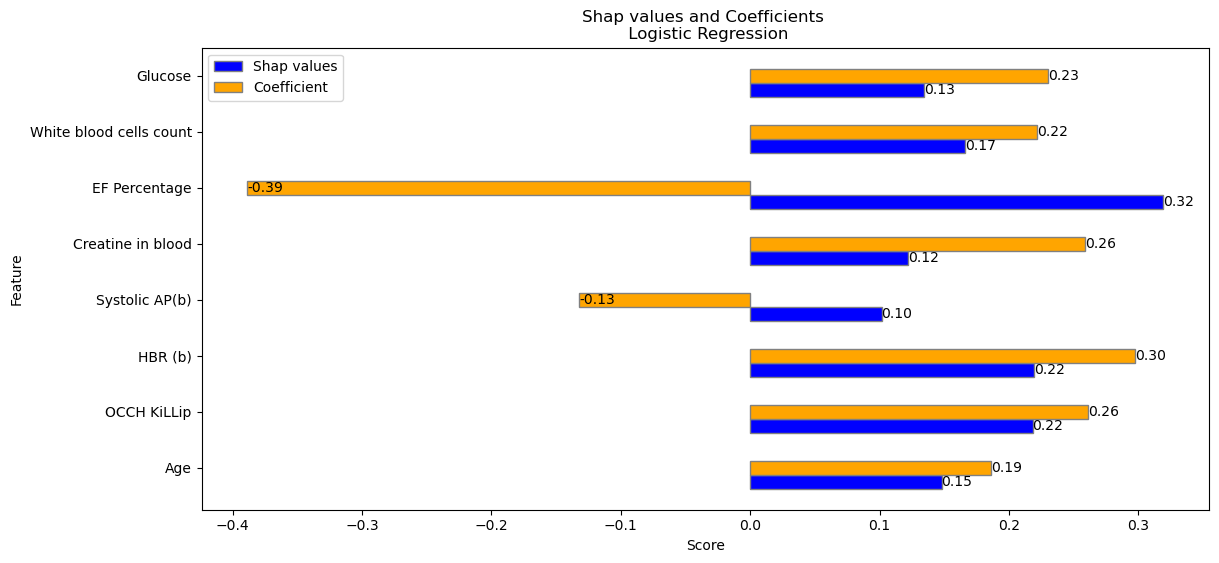

In [8]:
plot_weights(feature_importances, 
             column1='mean_shap', 
             column2='mean_coef', 
             label1='Shap values', 
             label2='Coefficient', 
             title='Shap values and Coefficients \n Logistic Regression',
             num_digits=2)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


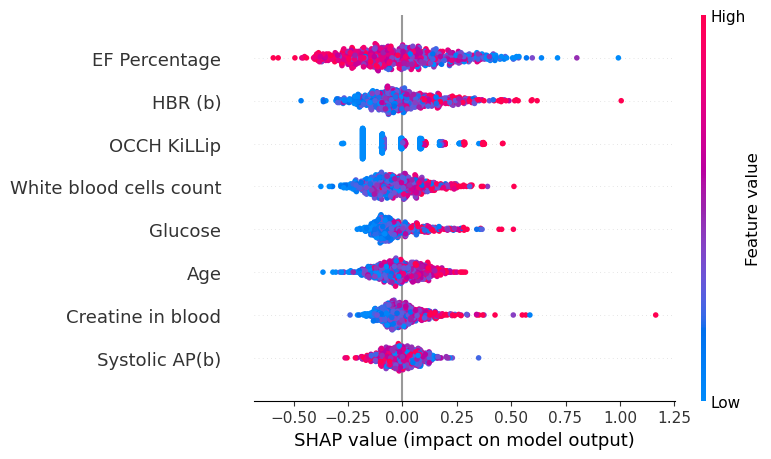

In [21]:
mean_shap_values = np.mean(shap_values_list, axis=0)
shap.summary_plot(mean_shap_values, X_test, feature_names=feature_names)